# making dataset ready

In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.8 MB/s eta 0:00:00


In [3]:
!pip install wordcloud


In [4]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 10.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from contractions import contractions_dict
import contractions
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# nlp models

In [6]:
# Load Data
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")


In [7]:
# Inspect the data
print(train_df['preprocessed_tweet'].head())
print(val_df['preprocessed_tweet'].head())
print(test_df['preprocessed_tweet'].head())

# Check for missing values
print(train_df['preprocessed_tweet'].isnull().sum())
print(val_df['preprocessed_tweet'].isnull().sum())
print(test_df['preprocessed_tweet'].isnull().sum())

# Drop rows with missing values in 'cleaned_tweet'
train_df = train_df.dropna(subset=['preprocessed_tweet'])
val_df = val_df.dropna(subset=['preprocessed_tweet'])
test_df = test_df.dropna(subset=['preprocessed_tweet'])

0    charlie jacob got confused ice bucket challeng...
1          playin pussy hole bingo drawing next number
2    telling mcgirt music aint enoughyou got non mu...
3    aint show bout dem colored diamond talk da rad...
4    yall claim want good amp loyal girl keep messi...
Name: preprocessed_tweet, dtype: object
0                               hoe bust ha knee cap
1    know talk lot shit bitch best believe back shit
2                                 people house bitch
3                                   got eye red bone
4     gota hand fulla brother trek gang bitch hustle
Name: preprocessed_tweet, dtype: object
0    confusing circumstance seem get way high ho virgo
1    psa big booty hoe tig ol bitties xbox onepanca...
2    maybe shoulda informed cousin social anxiety t...
3     fuck throwing batting practice tonight holy shit
4                                   want attention hoe
Name: preprocessed_tweet, dtype: object
1
0
1


In [8]:
# Convert all entries in the 'preprocessed_tweet' column to strings
train_df['preprocessed_tweet'] = train_df['preprocessed_tweet'].astype(str)
val_df['preprocessed_tweet'] = val_df['preprocessed_tweet'].astype(str)
test_df['preprocessed_tweet'] = test_df['preprocessed_tweet'].astype(str)


# bert

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
272/272 [==============================] - 243s 709ms/step - loss: 0.6327 - accuracy: 0.7734 - val_loss: 0.5870 - val_accuracy: 0.7721
Epoch 2/4
272/272 [==============================] - 190s 699ms/step - loss: 0.5707 - accuracy: 0.7883 - val_loss: 0.5467 - val_accuracy: 0.7867
Epoch 3/4
272/272 [==============================] - 189s 695ms/step - loss: 0.5474 - accuracy: 0.7958 - val_loss: 0.5196 - val_accuracy: 0.7993
Epoch 4/4
272/272 [==============================] - 188s 691ms/step - loss: 0.5351 - accuracy: 0.7987 - val_loss: 0.5099 - val_accuracy: 0.8114


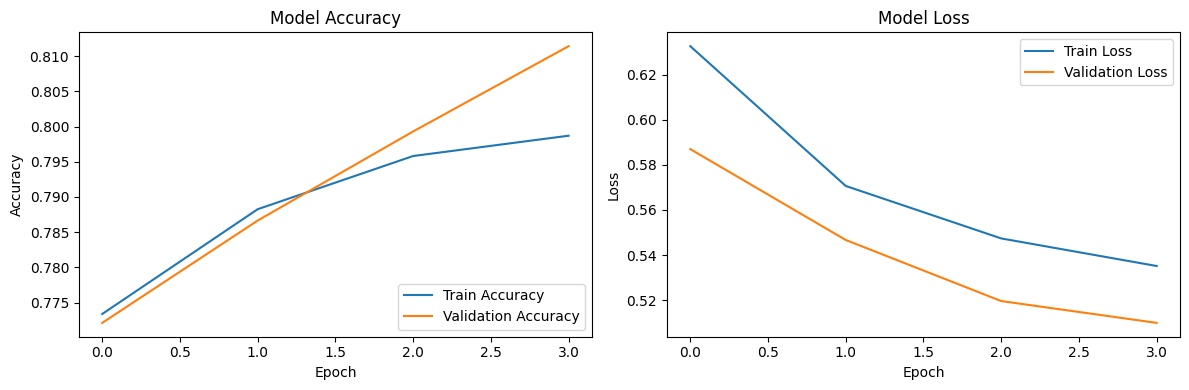

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


# Define constants
MAX_LENGTH = 128
BATCH_SIZE = 64
EPOCHS = 4
NUM_LABELS = 3

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Function to tokenize the data
def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize inputs
train_encodings = tokenize_data(train_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)
val_encodings = tokenize_data(val_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)
test_encodings = tokenize_data(test_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)

# Labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values


# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_df)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(BATCH_SIZE)

# Load the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS)

# Freeze all layers except the classification layer
for layer in model.layers[:-1]:
    layer.trainable = False


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model', save_best_only=True, save_weights_only=True, save_format='tf')  # Changed save_format
]


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


59/59 [==============================] - 31s 529ms/step - loss: 0.5107 - accuracy: 0.8082
Test Loss: 0.5106999278068542
Test Accuracy: 0.8081786632537842
59/59 [==============================] - 31s 517ms/step


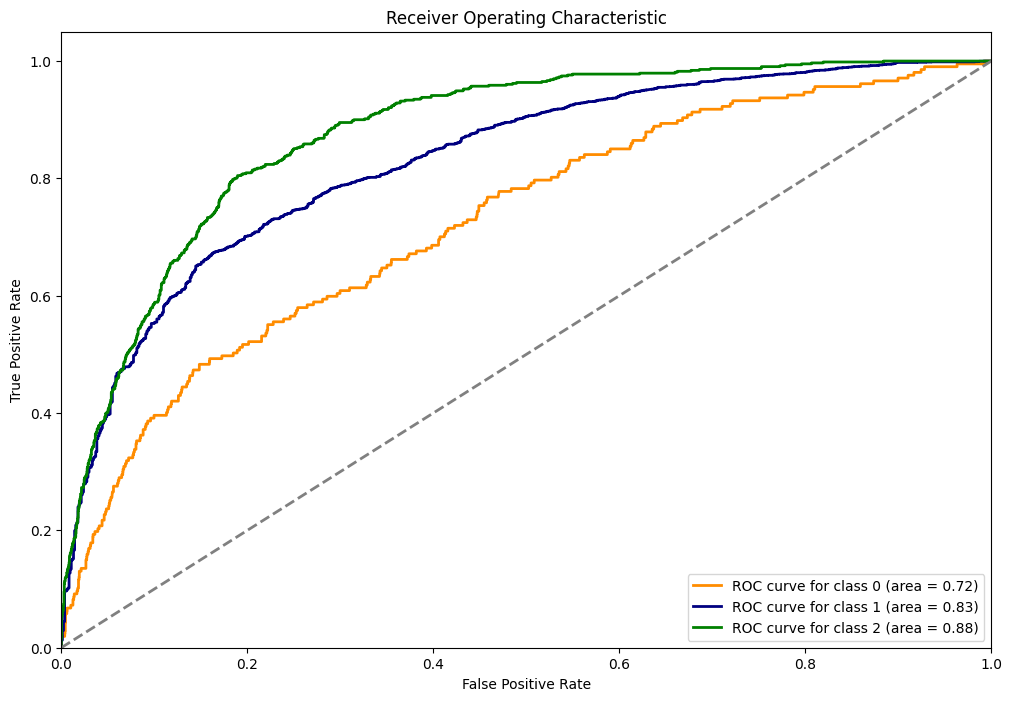

Precision: 0.7490043116959441
Recall: 0.8081786386871133
F1 Score: 0.764051802923053
Confusion Matrix:
[[   0  182   25]
 [   1 2799   80]
 [   1  424  205]]


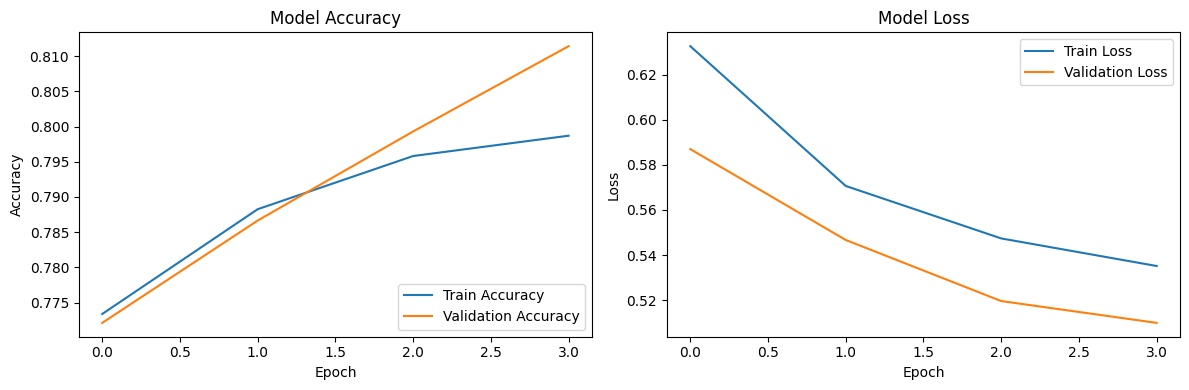

In [30]:
# Load the best weights
model.load_weights('best_model')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
predictions = model.predict(test_dataset).logits
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUM_LABELS):
    fpr[i], tpr[i], _ = roc_curve(test_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(12, 8))
colors = ['darkorange', 'navy', 'green']
for i in range(NUM_LABELS):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [31]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


# bertweet

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
272/272 [==============================] - 243s 704ms/step - loss: 0.5519 - accuracy: 0.7977 - val_loss: 0.5189 - val_accuracy: 0.7926
Epoch 2/4
272/272 [==============================] - 177s 649ms/step - loss: 0.5004 - accuracy: 0.8128 - val_loss: 0.6081 - val_accuracy: 0.7824
Epoch 3/4
272/272 [==============================] - 185s 680ms/step - loss: 0.4921 - accuracy: 0.8153 - val_loss: 0.4972 - val_accuracy: 0.8009
Epoch 4/4
272/272 [==============================] - 190s 698ms/step - loss: 0.4885 - accuracy: 0.8198 - val_loss: 0.4385 - val_accuracy: 0.8300


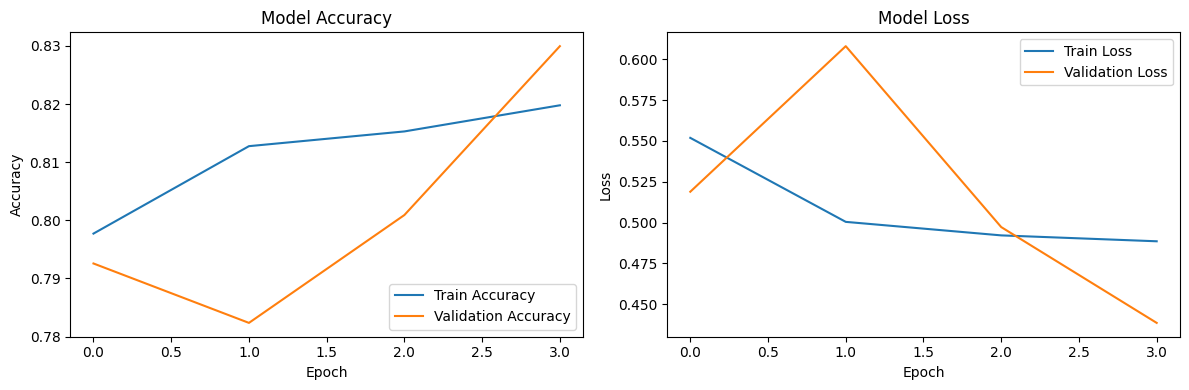

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification, TFRobertaForSequenceClassification,AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


# Define constants
MAX_LENGTH = 128
BATCH_SIZE = 64
EPOCHS = 4
NUM_LABELS = 3

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)

# Function to tokenize the data
def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize inputs
train_encodings = tokenize_data(train_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)
val_encodings = tokenize_data(val_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)
test_encodings = tokenize_data(test_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)

# Labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_df)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(BATCH_SIZE)

# Load the model
# model = TFBertForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=NUM_LABELS)
# model = TFRobertaForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=NUM_LABELS)
# Load the model
model = TFRobertaForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=NUM_LABELS)

# Freeze all layers except the classification layer
for layer in model.layers[:-1]:
    layer.trainable = False
# Freeze all layers except the classification layer
for layer in model.layers[:-1]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model', save_best_only=True, save_weights_only=True, save_format='tf')
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


59/59 [==============================] - 29s 486ms/step - loss: 0.4414 - accuracy: 0.8354
Test Loss: 0.441444456577301
Test Accuracy: 0.8353511095046997
59/59 [==============================] - 38s 483ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


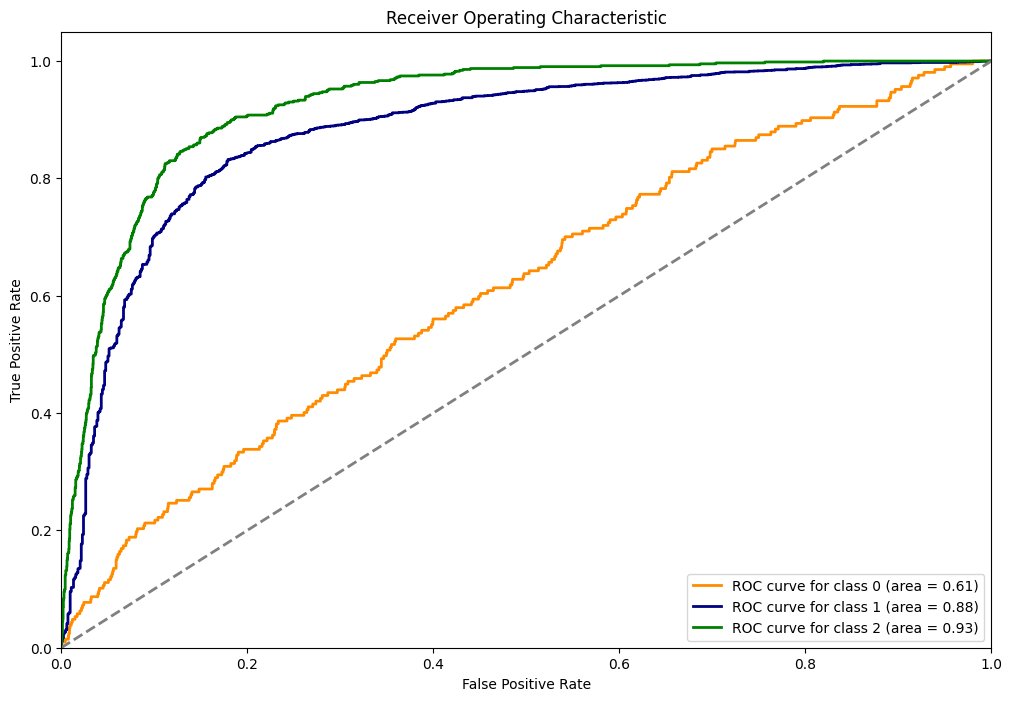

Precision: 0.7817342461137797
Recall: 0.8353510895883777
F1 Score: 0.8031374272035889
Confusion Matrix:
[[   0  182   25]
 [   0 2777  103]
 [   0  302  328]]


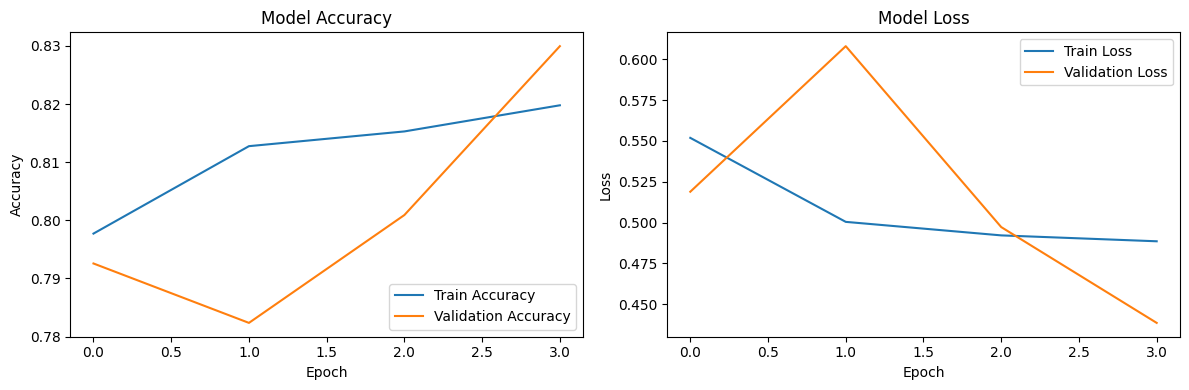

In [12]:
# Load the best weights
model.load_weights('best_model')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
predictions = model.predict(test_dataset).logits
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUM_LABELS):
    fpr[i], tpr[i], _ = roc_curve(test_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(12, 8))
colors = ['darkorange', 'navy', 'green']
for i in range(NUM_LABELS):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## roberta preprocessed

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/4
272/272 [==============================] - 245s 785ms/step - loss: 0.5724 - accuracy: 0.7984 - val_loss: 0.4734 - val_accuracy: 0.8106
Epoch 2/4
272/272 [==============================] - 190s 698ms/step - loss: 0.5009 - accuracy: 0.8159 - val_loss: 0.4292 - val_accuracy: 0.8316
Epoch 3/4
272/272 [==============================] - 196s 719ms/step - loss: 0.4833 - accuracy: 0.8213 - val_loss: 0.4054 - val_accuracy: 0.8432
Epoch 4/4
272/272 [==============================] - 178s 655ms/step - loss: 0.4704 - accuracy: 0.8295 - val_loss: 0.4161 - val_accuracy: 0.8523


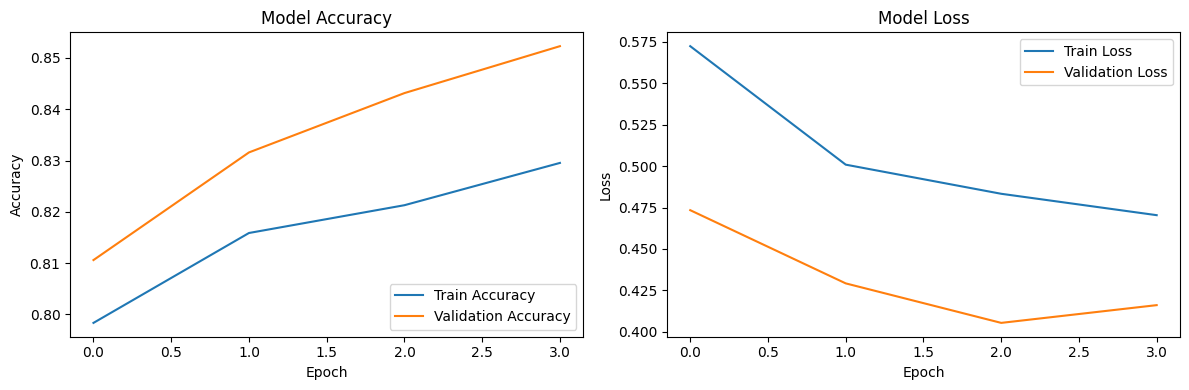

In [35]:
# Define constants
MAX_LENGTH = 128
BATCH_SIZE = 64
EPOCHS = 4
NUM_LABELS = 3
model_name = 'roberta-base'

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Function to tokenize the data
def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize inputs
train_encodings = tokenize_data(train_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)
val_encodings = tokenize_data(val_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)
test_encodings = tokenize_data(test_df['preprocessed_tweet'], tokenizer, MAX_LENGTH)

# Labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: class_weights[i] for i in range(NUM_LABELS)}

# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_df)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(BATCH_SIZE)

# Load the model
model = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)

# Freeze all layers except the classification layer
for layer in model.layers[:-1]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model', save_best_only=True, save_weights_only=True, save_format='tf')
]

# Train the model with class weights
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict  # Include class weights here
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



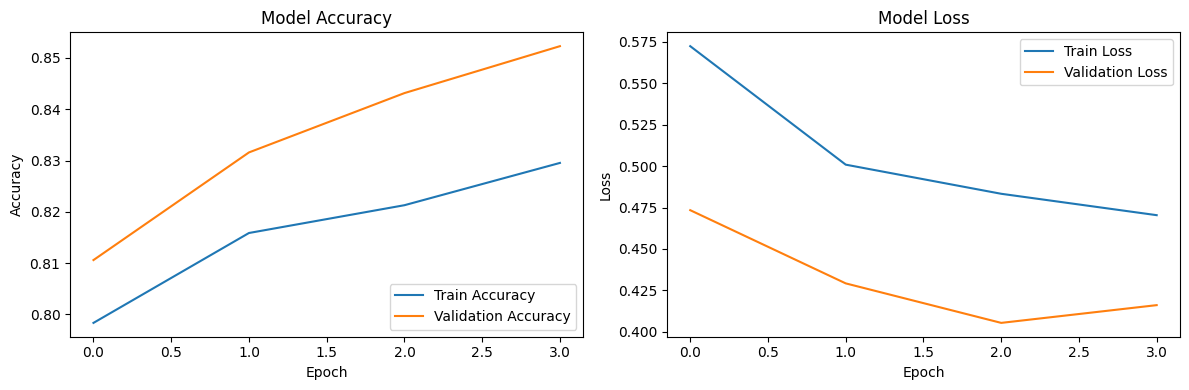

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


59/59 [==============================] - 29s 488ms/step - loss: 0.3992 - accuracy: 0.8458
Test Loss: 0.3992050290107727
Test Accuracy: 0.8458434343338013
59/59 [==============================] - 38s 488ms/step


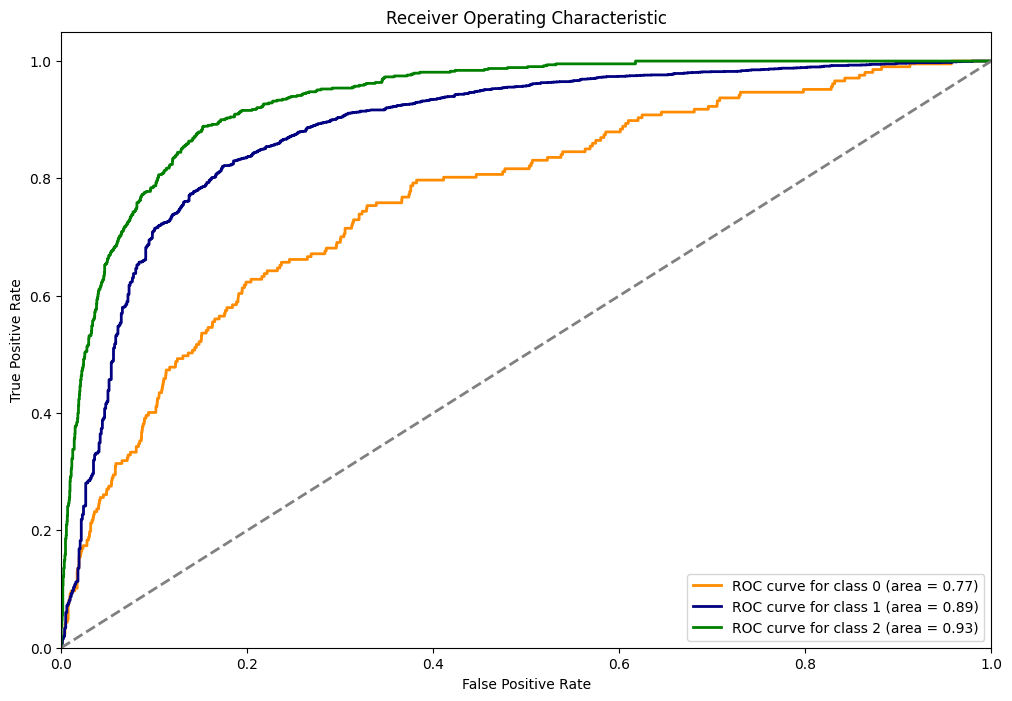

Precision: 0.8288772458568694
Recall: 0.8458434221146085
F1 Score: 0.8163472822517365
Confusion Matrix:
[[   5  179   23]
 [   3 2792   85]
 [   0  283  347]]


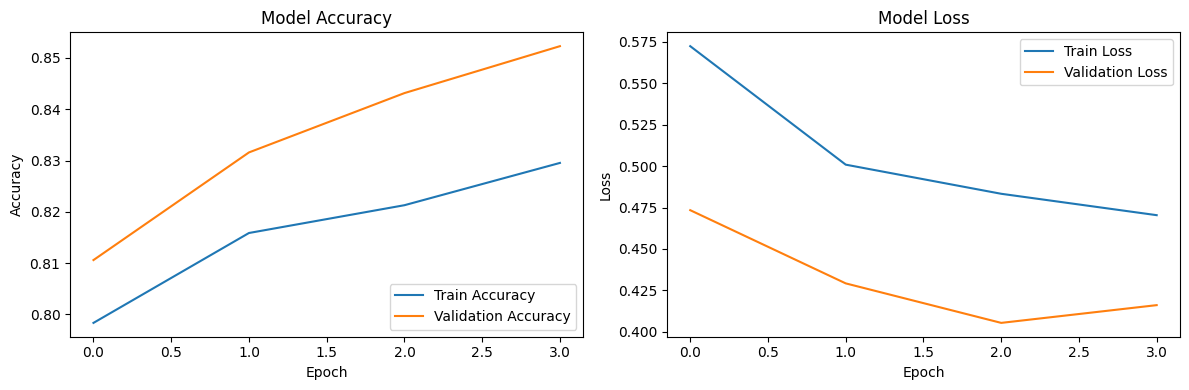

In [37]:
# Load the best weights
model.load_weights('best_model')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
predictions = model.predict(test_dataset).logits
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUM_LABELS):
    fpr[i], tpr[i], _ = roc_curve(test_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(12, 8))
colors = ['darkorange', 'navy', 'green']
for i in range(NUM_LABELS):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [38]:
# Print confusion matrix as a table with labels
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['True: 0 - Hate Speech', 'True: 1 - Offensive Language', 'True: 2 - Neither'],
                              columns=['Predicted: 0 - Hate Speech', 'Predicted: 1 - Offensive Language', 'Predicted: 2 - Neither'])

print("Confusion Matrix:")
conf_matrix_df

Confusion Matrix:


,Predicted: 0 - Hate Speech,Predicted: 1 - Offensive Language,Predicted: 2 - Neither
True: 0 - Hate Speech,5,179,23
True: 1 - Offensive Language,3,2792,85
True: 2 - Neither,0,283,347


## tweet